In [308]:
import numpy as np
import pandas as pd

import talib # Thư viện các chỉ báo kỹ thuật
from datetime import datetime

from binance.client import Client #Nguồn thu nhập dữ liệu về giá


In [309]:
client = Client('JLCON0ZJ9v4zX595o2W1rlvSIhIercTu2ugNLCMPZ88QAt8zvSe2vY3LDiiRjKMB','JMnozKSUlep8mBrXCW1b7mAdHDl5qcYv3GDfNOquyifCdbD4QmGXILR9A5V0FgKf') ## Nhập API key của Binance
start_str = 'Jan 1, 2021' ## Mốc thời gian giao dịch.
end_str = '' ## Nếu để trống thì có nghĩa là lấy mốc thời gian kết thúc là hiện tại.
coin = 'BTC' ## Tên đồng tiền muốn giao dịch với mã BTC/USDT
klines = client.get_historical_klines(symbol=f'{coin}USDT', interval=client.KLINE_INTERVAL_1DAY, start_str=start_str)  ##craw dữ liệu
df = pd.DataFrame(klines)
df = df.iloc[:,:6] ## Chỉ lấy 6 cột đầu. bao gồm thời gian, giá mở cửa, giá cao nhất, giá thấp nhất, giá đóng cửa, khối lượng giao dịch.
df.columns = ['time','open','high','low','close','volume']
df = df.astype(float) ## Dữ liệu đang ở dạng string nên cần chuyển qua float.
df['time'] = [datetime.fromtimestamp(ts / 1000) for ts in df['time']] ##chuyển định dạng timestamp sang thời gian chuẩn YY/MM/DD 00:00 UTC

df.tail()

,time,open,high,low,close,volume
702,2022-12-04 07:00:00,16885.20,17202.84,16878.25,17105.70,178619.13387
703,2022-12-05 07:00:00,17106.65,17424.25,16867.00,16966.35,233703.29225
704,2022-12-06 07:00:00,16966.35,17107.01,16906.37,17088.96,218730.76883
705,2022-12-07 07:00:00,17088.96,17142.21,16678.83,16836.64,220657.41334
706,2022-12-08 07:00:00,16836.64,16890.01,16733.49,16850.05,115400.58992


In [310]:
open = df['open']
high = df['high']
low  = df['low']
close = df['close']
volume = df['volume']
df.dropna()
avg = (df['high'] + df['low']) / 2

## Bổ sung các giá trị chỉ báo kỹ thuật vào DataFrame
##Overlap Studies
df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['BBANDS_upperband'] = (df['BBANDS_upperband'] - avg) / close
df['BBANDS_middleband'] = (df['BBANDS_middleband'] - avg) / close
df['BBANDS_lowerband'] = (df['BBANDS_lowerband'] - avg) / close
df['DEMA'] = (talib.DEMA(close, timeperiod=30) - avg) / close
df['EMA'] = (talib.EMA(close, timeperiod=30) - avg) / close
df['HT_TRENDLINE'] = (talib.HT_TRENDLINE(close) - avg) / close
df['KAMA'] = (talib.KAMA(close, timeperiod=30) - avg) / close
df['MA'] = (talib.MA(close, timeperiod=30, matype=0) - avg) / close
df['MIDPOINT'] = (talib.MIDPOINT(close, timeperiod=14) - avg) / close
df['SMA'] = (talib.SMA(close, timeperiod=30) - avg) / close
df['T3'] = (talib.T3(close, timeperiod=5, vfactor=0) - avg) / close
df['TEMA'] = (talib.TEMA(close, timeperiod=30) - avg) / close
df['TRIMA'] = (talib.TRIMA(close, timeperiod=30) - avg) / close
df['WMA'] = (talib.WMA(close, timeperiod=30) - avg) / close
df['LINEARREG'] = (talib.LINEARREG(close, timeperiod=14) - close) / close
df['LINEARREG_INTERCEPT'] = (talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close) / close

df['AD'] = talib.AD(high, low, close, volume) / close
df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10) / close
df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0) / close
df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
df['HT_PHASOR_inphase'] /= close
df['HT_PHASOR_quadrature'] /= close
df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14) / close
df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD_macd'] /= close
df['MACD_macdsignal'] /= close
df['MACD_macdhist'] /= close
df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14) / close
df['MOM'] = talib.MOM(close, timeperiod=10) / close
df['OBV'] = talib.OBV(close, volume) / close
df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14) / close
df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1) / close
df['TRANGE'] = talib.TRANGE(high, low, close) / close

##Momentum Indicators
df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
df['BOP'] = talib.BOP(open, high, low, close)
df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
df['DX'] = talib.DX(high, low, close, timeperiod=14)

df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
df['RSI'] = talib.RSI(close, timeperiod=14)
df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
df['TRIX'] = talib.TRIX(close, timeperiod=30)
df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

df['ATR'] = talib.ATR(high, low, close, timeperiod=14)  # Chỉ báo về biên động thị trường
df['NATR'] = talib.NATR(high, low, close, timeperiod=14)

df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

df['BETA'] = talib.BETA(high, low, timeperiod=5)
df['CORREL'] = talib.CORREL(high, low, timeperiod=30)

df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)


## Pattern Recognition

In [311]:
#Phân nhóm dữ liệu
##Ở đây diff chỉ ra khoảng cách lớn nhất của 2 mức giá trong 1 khung giờ, qua đó nếu các khung nến sau đó liên tămg hơn giá trị trung bình về diff thì lúc này thị trường đang có xu hướng lên (uptrend) và ngược lại là downtrend
diff = (df['high'] - df['low'])
diff =pd.DataFrame.median(diff)
pipdiff = diff  # for TP
SLTPRatio = 2   # pipdiff/Ratio gives SL
## Ở đây

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length

    for line in range(0, length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1, barsupfront + 2):
            value1 = open[line + 1] - low[line + i]
            value2 = open[line + 1] - high[line + i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ((valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff / SLTPRatio))):
                trendcat[line] = 1  # -1 downtrend
                break
            elif ((valueOpenLow <= (pipdiff / SLTPRatio)) and (-valueOpenHigh >= pipdiff)):
                trendcat[line] = 2  # uptrend
                break
            else:
                trendcat[line] = 0  # no clear trend

    return trendcat
df['mytarget'] = mytarget(16, df) ##thêm 1 cột về xu thế thị trường vào DataFrame

df.to_csv('target.csv',index =False)


In [312]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
    'MOM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',

    'ULTOSC',
    'WILLR',

    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])
df = df.dropna()
X = df[features]
y = df["mytarget"]


In [313]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)  #Chia dữ liệu phục vụ cho model


In [314]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model = XGBClassifier() ##Ở bài toán này em dùng thuật toán XGBC để có thể thực hiện train data
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))


****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 53.7190%


In [315]:
##Kiểm tra lại độ chính xác của model đã train
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

C:\Users\DAD\AppData\Local\Temp\ipykernel_16264\2359861386.py:4: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 30.5785%


In [316]:
## Lưu lại model đã train , để cập nhật model thì chỉ cần dùng đến chúc năng Save Model là được.
import joblib

##Save Model
# filename = 'mymodel1.sav'
# joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

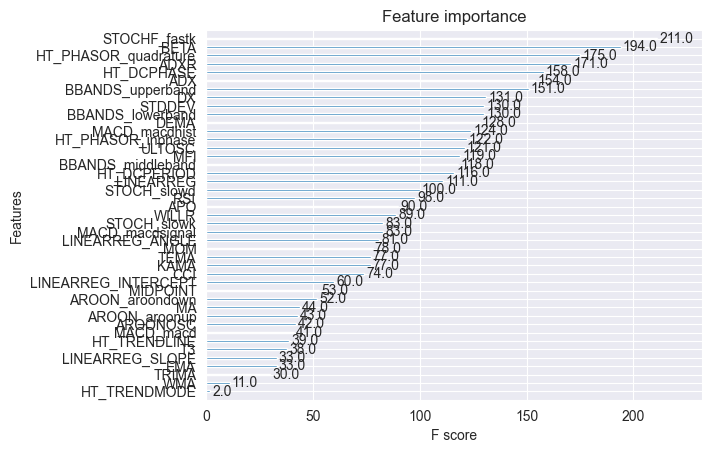

In [317]:
#Đánh giá về mức độ quan trọng của các chỉ báo đối với kết quả.
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()


In [318]:
## Thực hiện kiểm tra model liệu có đạt được mức lãi như kỳ vọng,
##ở đây ví dụ với tài khoản gốc có 100 USD, thời gian giao dịch tính từ
balance = 100.00
tokenunit = 0.00
buy = True
buys =[]
sells = []


for i in range(len(df)) :
    X_stream  = df.iloc[[i]]
    X_model = X_stream[features]
    ModelPrediction = loaded_model.predict(X_model)
    #Buy Signal
    if ModelPrediction == 2 and buy == True :
         tokenunit = balance/df['close'].iloc[i]
         buys.append([df['time'].iloc[i],df['close'].iloc[i],balance])



         buy = False
    if ModelPrediction == 1 and buy == False :
        balance = tokenunit*df['close'].iloc[i]
        sells.append([df['time'].iloc[i],df['close'].iloc[i],balance])
        tokenunit=0

        buy = True


for i in range(len(sells)) :
    profit = sells[i][2] - buys[i][2]
    print("Mua",buys[i],"Bán",sells[i],"\n","Lợi nhuậnt",profit)
print("Số dư tài khoản hiện có :",balance)


Mua [Timestamp('2021-04-03 07:00:00'), 57051.94, 100.0] Bán [Timestamp('2021-04-29 07:00:00'), 53555.0, 93.87060282262092] 
 Lợi nhuậnt -6.129397177379076
Mua [Timestamp('2021-05-19 07:00:00'), 36690.09, 93.87060282262092] Bán [Timestamp('2021-06-14 07:00:00'), 40516.29, 103.65983202647168] 
 Lợi nhuậnt 9.789229203850752
Mua [Timestamp('2021-06-17 07:00:00'), 38092.97, 103.65983202647168] Bán [Timestamp('2021-06-24 07:00:00'), 34663.09, 94.32633073552599] 
 Lợi nhuậnt -9.33350129094569
Mua [Timestamp('2021-07-05 07:00:00'), 33690.14, 94.32633073552599] Bán [Timestamp('2021-07-30 07:00:00'), 42206.37, 118.1702425625415] 
 Lợi nhuậnt 23.843911827015518
Mua [Timestamp('2021-08-02 07:00:00'), 39147.82, 118.1702425625415] Bán [Timestamp('2021-08-09 07:00:00'), 46253.4, 139.61889825135236] 
 Lợi nhuậnt 21.44865568881086
Mua [Timestamp('2021-08-28 07:00:00'), 48895.35, 139.61889825135236] Bán [Timestamp('2021-09-01 07:00:00'), 48810.52, 139.37666926355163] 
 Lợi nhuậnt -0.2422289878007291
Mua

In [319]:
##Như ở đây số dư tài khoản test sau khi chạy đã lên đến 112 USD tức là đã lãi được 12% so với gốc ban đầu.